## Porto Seguro's Safe Driver Prediction
 - goal : predict insurance claim (classification problem 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import missingno as msno
import xgboost as xgb
import warnings
sns.set(style='white', context='notebook', palette='deep')

warnings.filterwarnings("ignore")

### Data understainding

In [56]:
np.random.seed(1989)
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [58]:
display(train.head())
display(test.head())

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [59]:
targets = train['target'].values

(0.0, 700000)

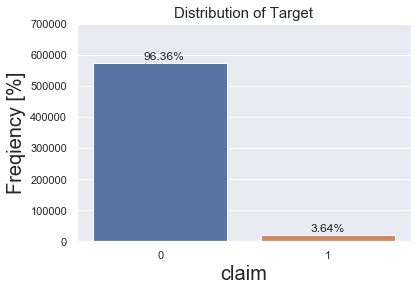

In [60]:
sns.set(style="darkgrid")
ax = sns.countplot(x= targets)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)),
                (p.get_x()+0.3, p.get_height()+10000))
plt.title("Distribution of Target", fontsize=15)
plt.xlabel("claim",fontsize=20)
plt.ylabel("Freqiency [%]", fontsize=20)
ax.set_ylim(top=700000)

### data check

In [61]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('Oh no')
print('Train and test sets are distinct.') if len(np.intersect1d(train.id.values, test.id.values)) == 0 else print('Oh no')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('Oh no')

Id is unique.
Train and test sets are distinct.
We do not need to worry about missing values.


### find null data

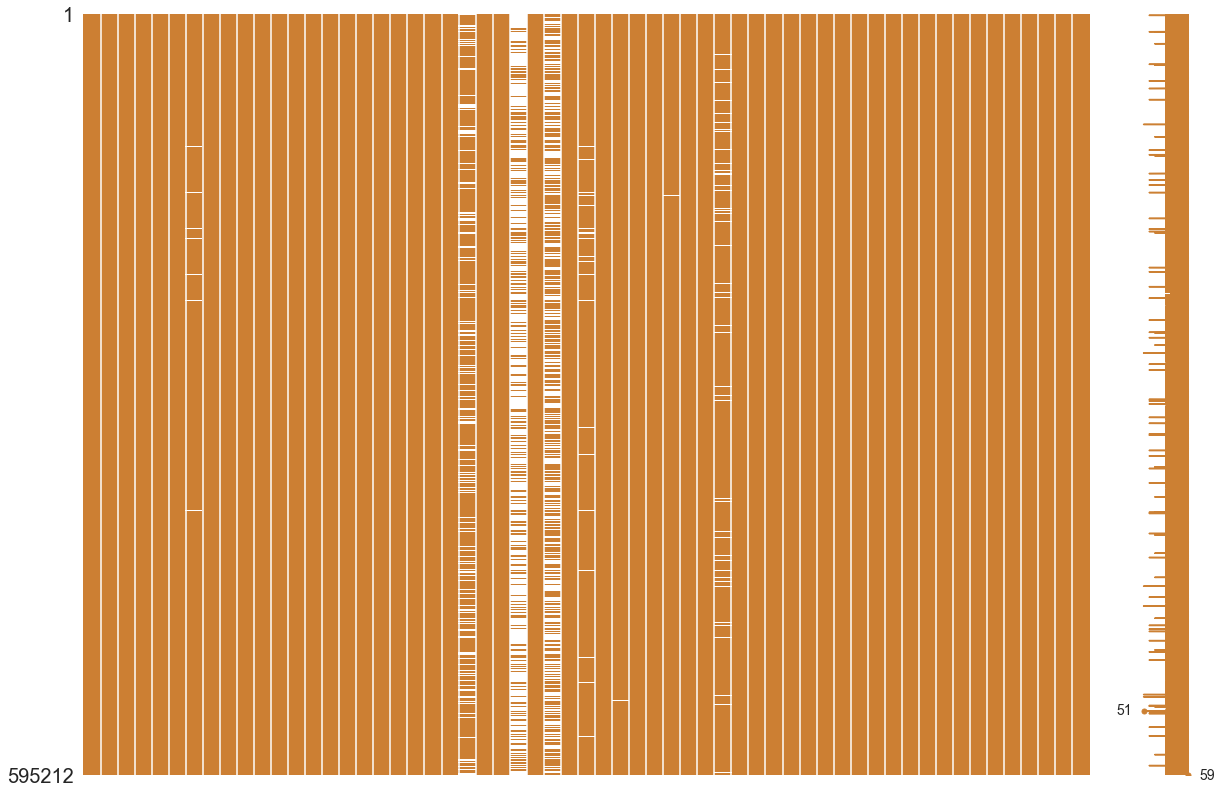

In [62]:
import missingno as msno

train_null = train
train_null = train_null.replace(-1, np.NaN)

msno.matrix(df=train_null.iloc[:, :], figsize=(20, 14), color=(0.8, 0.5, 0.2))

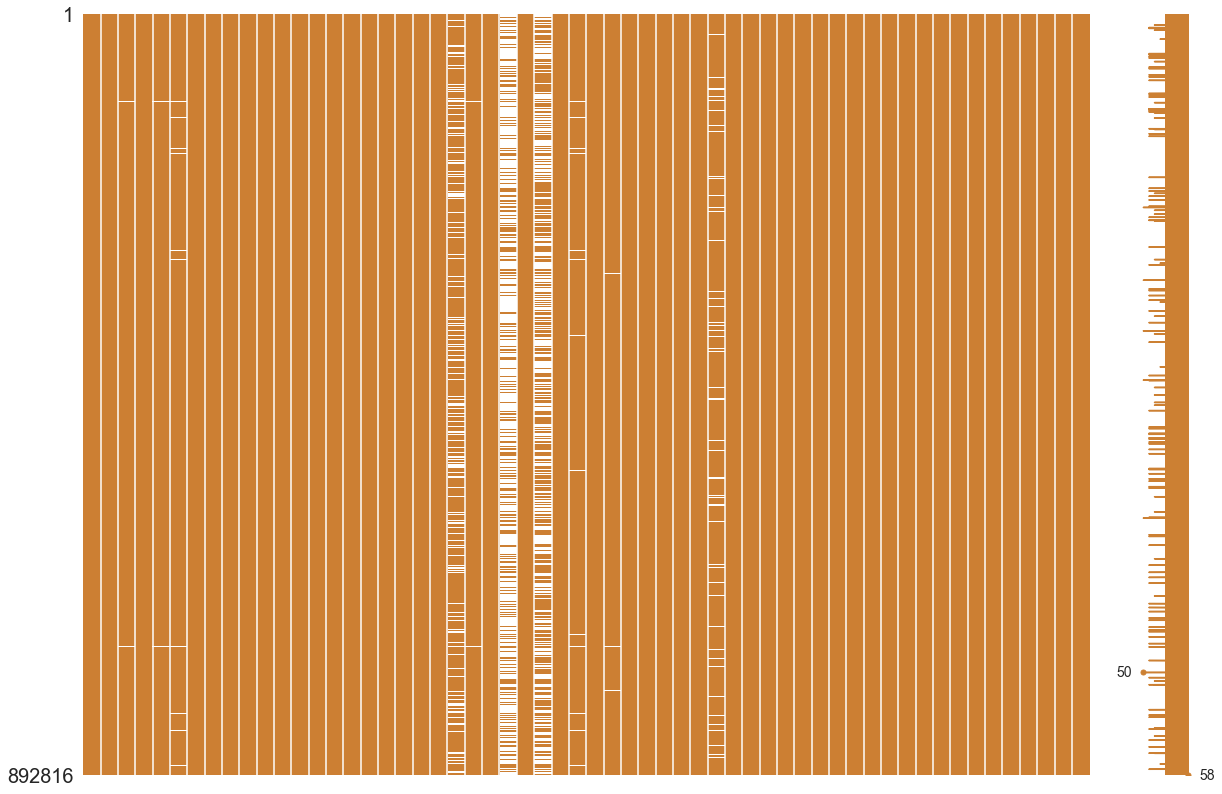

In [63]:
test_null = test
test_null = test_null.replace(-1, np.NaN)

msno.matrix(df=test_null.iloc[:, :], figsize=(20,14), color=(0.8,0.5,0.2))

In [64]:
# null이 한개라도 포함된 컬럼 찾기
train_null = train_null.loc[:, train_null.isnull().any()]
test_null = test_null.loc[:, test_null.isnull().any()]

print(train_null.columns)
print(test_null.columns)

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12',
       'ps_car_14'],
      dtype='object')
Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03',
       'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat',
       'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14'],
      dtype='object')


In [65]:
print('Columns \t Number of NaN')
for column in train_null.columns:
    print('{}:\t {}'.format(column, len(train_null[column][np.isnan(train_null[column])])))

Columns 	 Number of NaN
ps_ind_02_cat:	 216
ps_ind_04_cat:	 83
ps_ind_05_cat:	 5809
ps_reg_03:	 107772
ps_car_01_cat:	 107
ps_car_02_cat:	 5
ps_car_03_cat:	 411231
ps_car_05_cat:	 266551
ps_car_07_cat:	 11489
ps_car_09_cat:	 569
ps_car_11:	 5
ps_car_12:	 1
ps_car_14:	 42620


### feature analysis

In [81]:
feature_list = list(train.columns)
def groupFeatures(features):
    features_bin = []
    features_cat = []
    features_etc = []
    for feature in features:
        if 'bin' in feature:
            features_bin.append(feature)
        elif 'cat' in feature:
            features_cat.append(feature)
        elif 'id' in feature or 'target' in feature:
            continue
        else:
            features_etc.append(feature)
    return features_bin, features_cat, features_etc

feature_list_bin, feature_list_cat, feature_list_etc = groupFeatures(feature_list)
print("# of binary feature : ", len(feature_list_bin))
print("# of categorical feature : ", len(feature_list_cat))
print("# of other feature : ", len(feature_list_etc))

# of binary feature :  17
# of categorical feature :  14
# of other feature :  26


In [82]:
def TrainTestHistogram(train, test, feature):
    fig, axes = plt.subplots(len(feature), 2, figsize=(10, 40))
    fig.tight_layout()

    left  = 0  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.3   # the amount of width reserved for blank space between subplots
    hspace = 0.7   # the amount of height reserved for white space between subplot

    plt.subplots_adjust(left=left, bottom=bottom, right=right, 
                        top=top, wspace=wspace, hspace=hspace)
    count = 0
    for i, ax in enumerate(axes.ravel()):
        if i % 2 == 0:
            title = 'Train: ' + feature[count]
            ax.hist(train[feature[count]], bins=30, normed=False)
            ax.set_title(title)
        else:
            title = 'Test: ' + feature[count]
            ax.hist(test[feature[count]], bins=30, normed=False)
            ax.set_title(title)
            count = count + 1

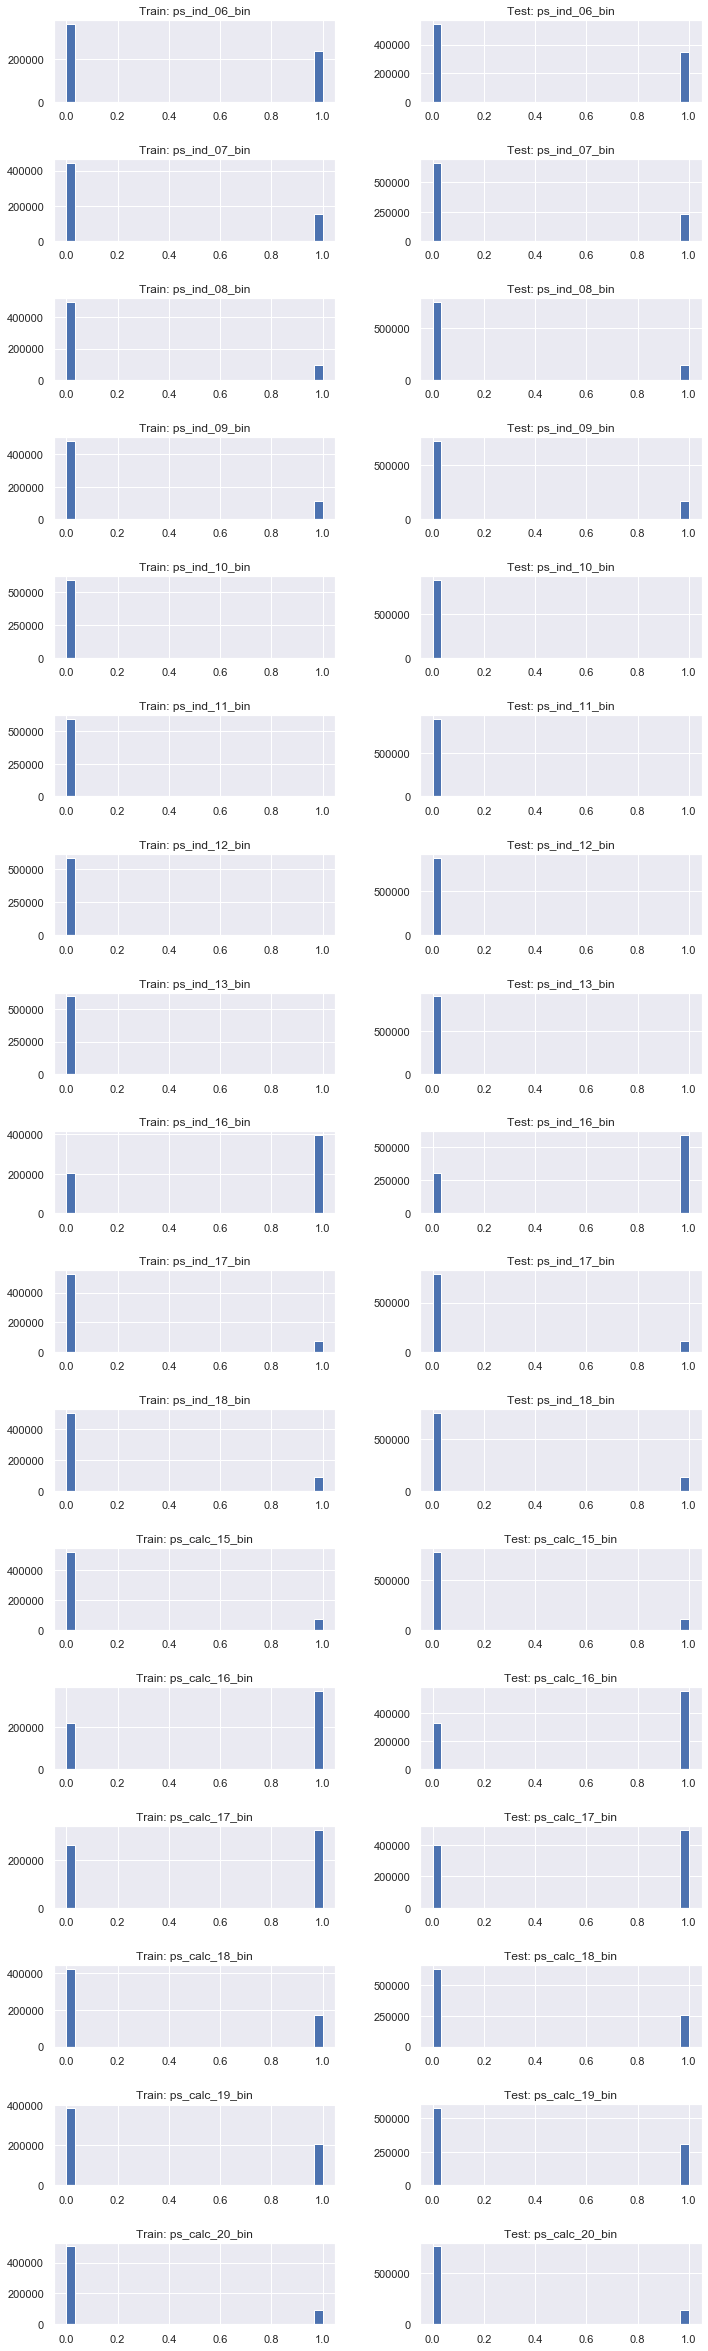

In [68]:
TrainTestHistogram(train, test, feature_list_bin)

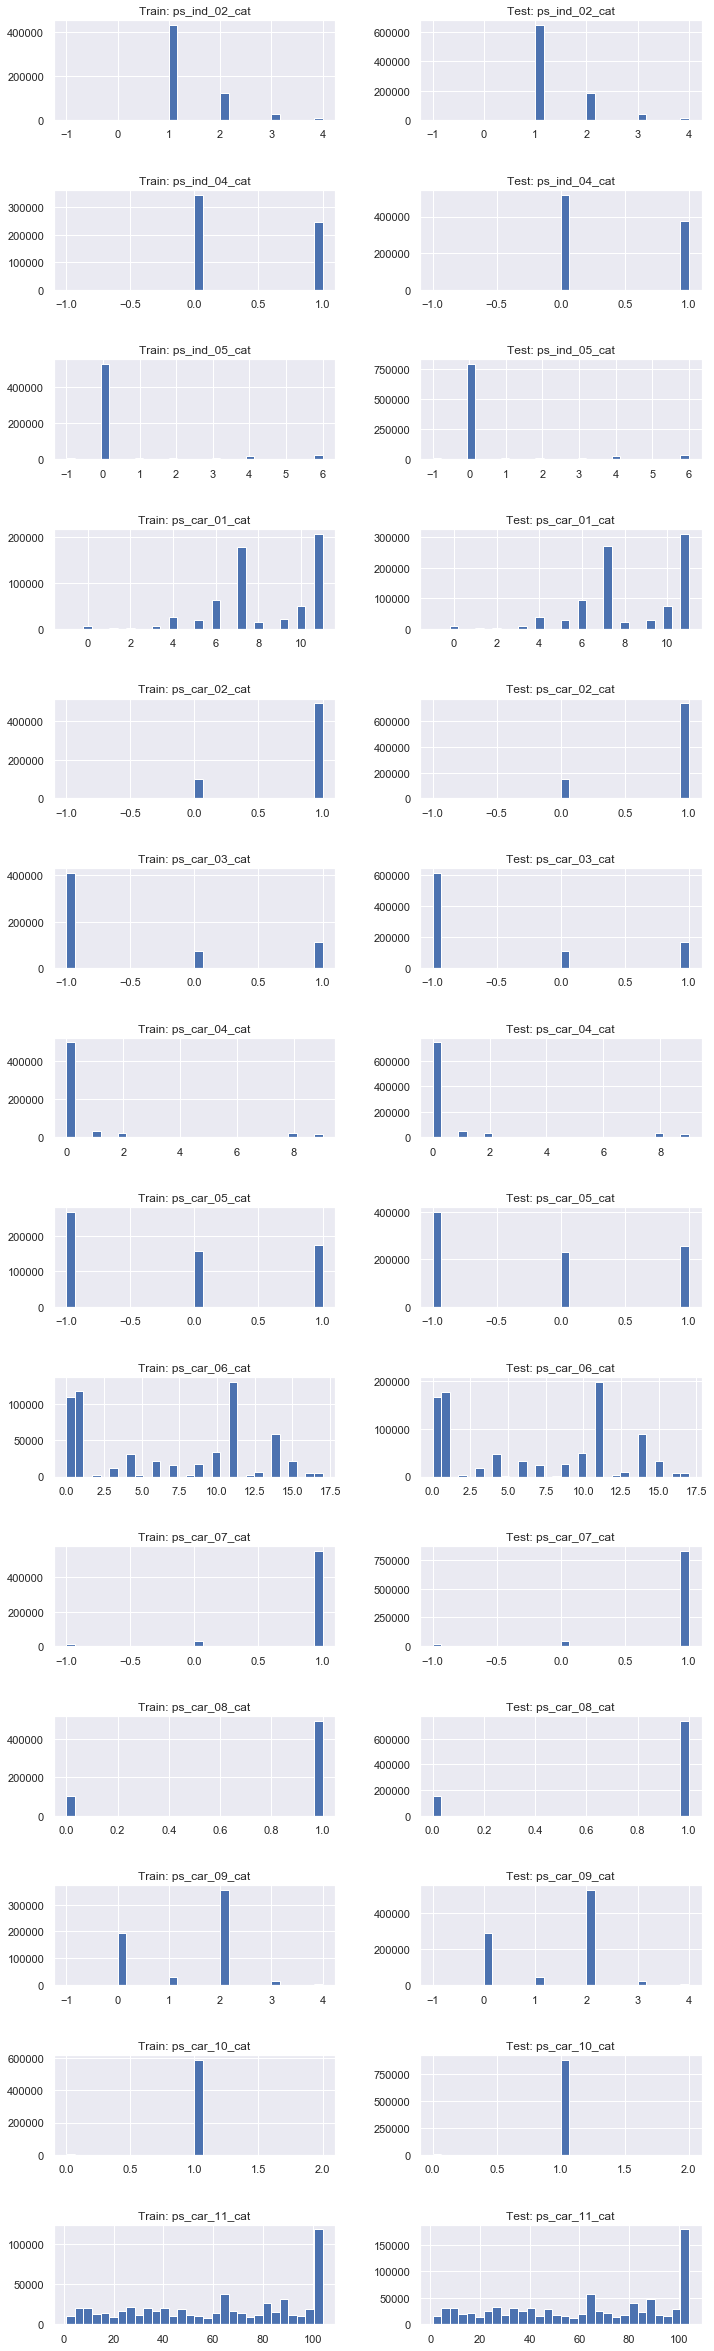

In [69]:
TrainTestHistogram(train, test, feature_list_cat)

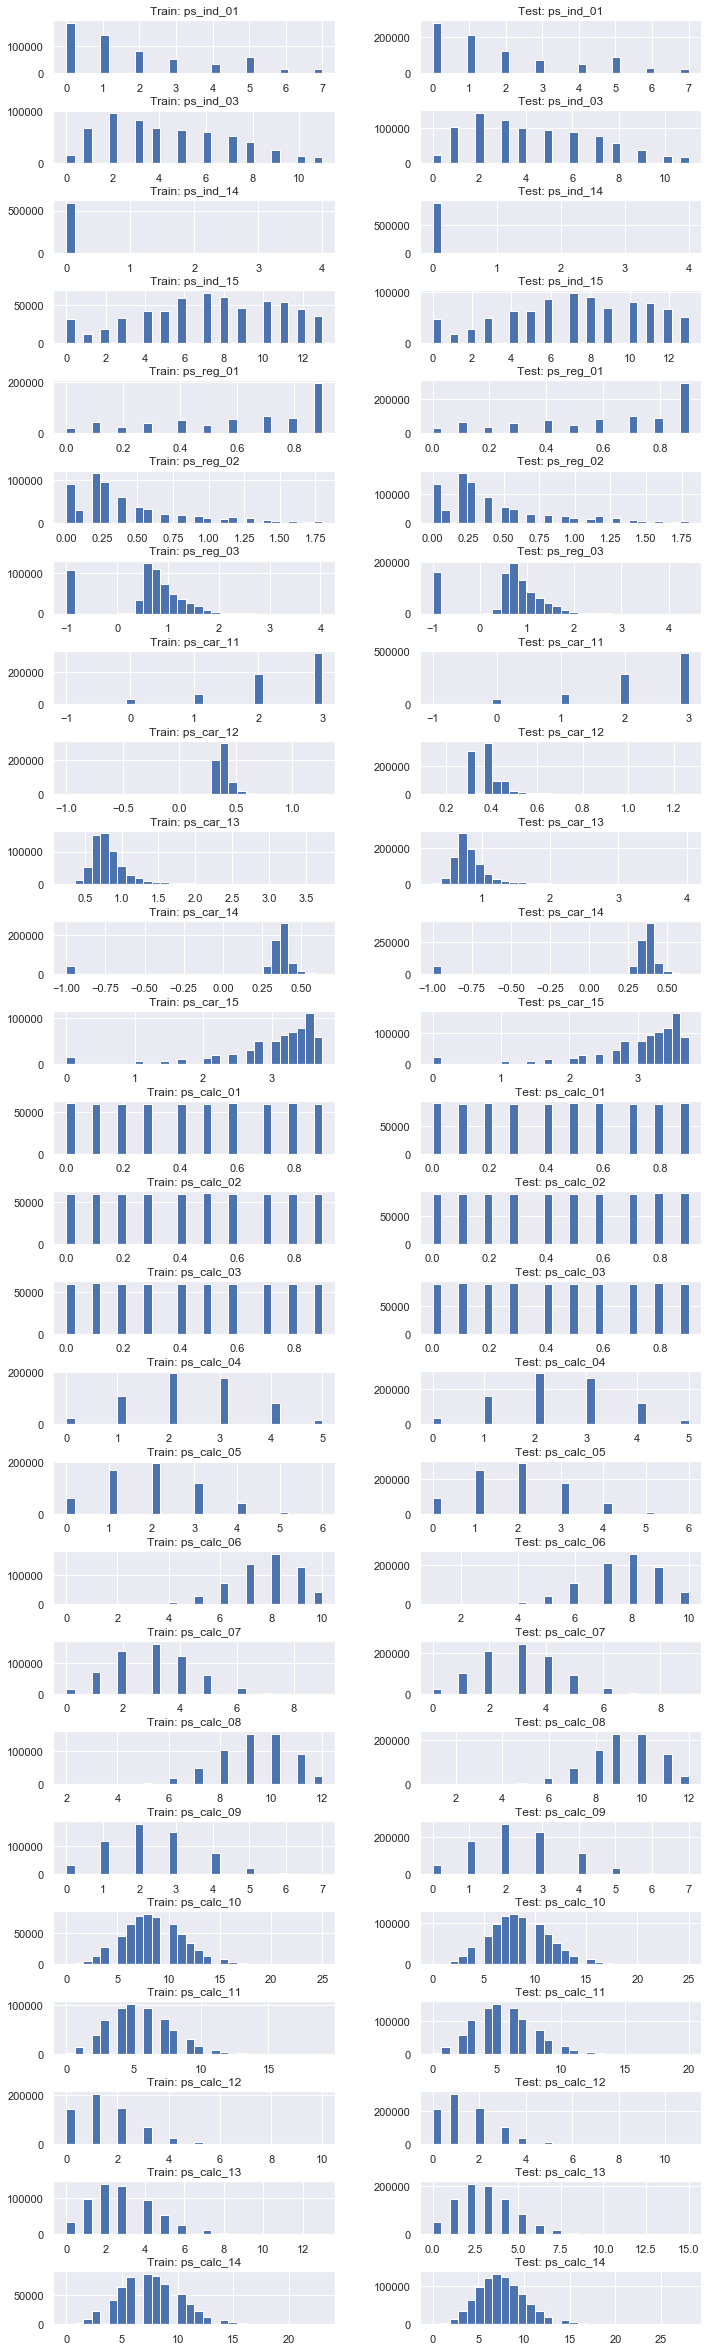

In [70]:
TrainTestHistogram(train, test, feature_list_etc)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

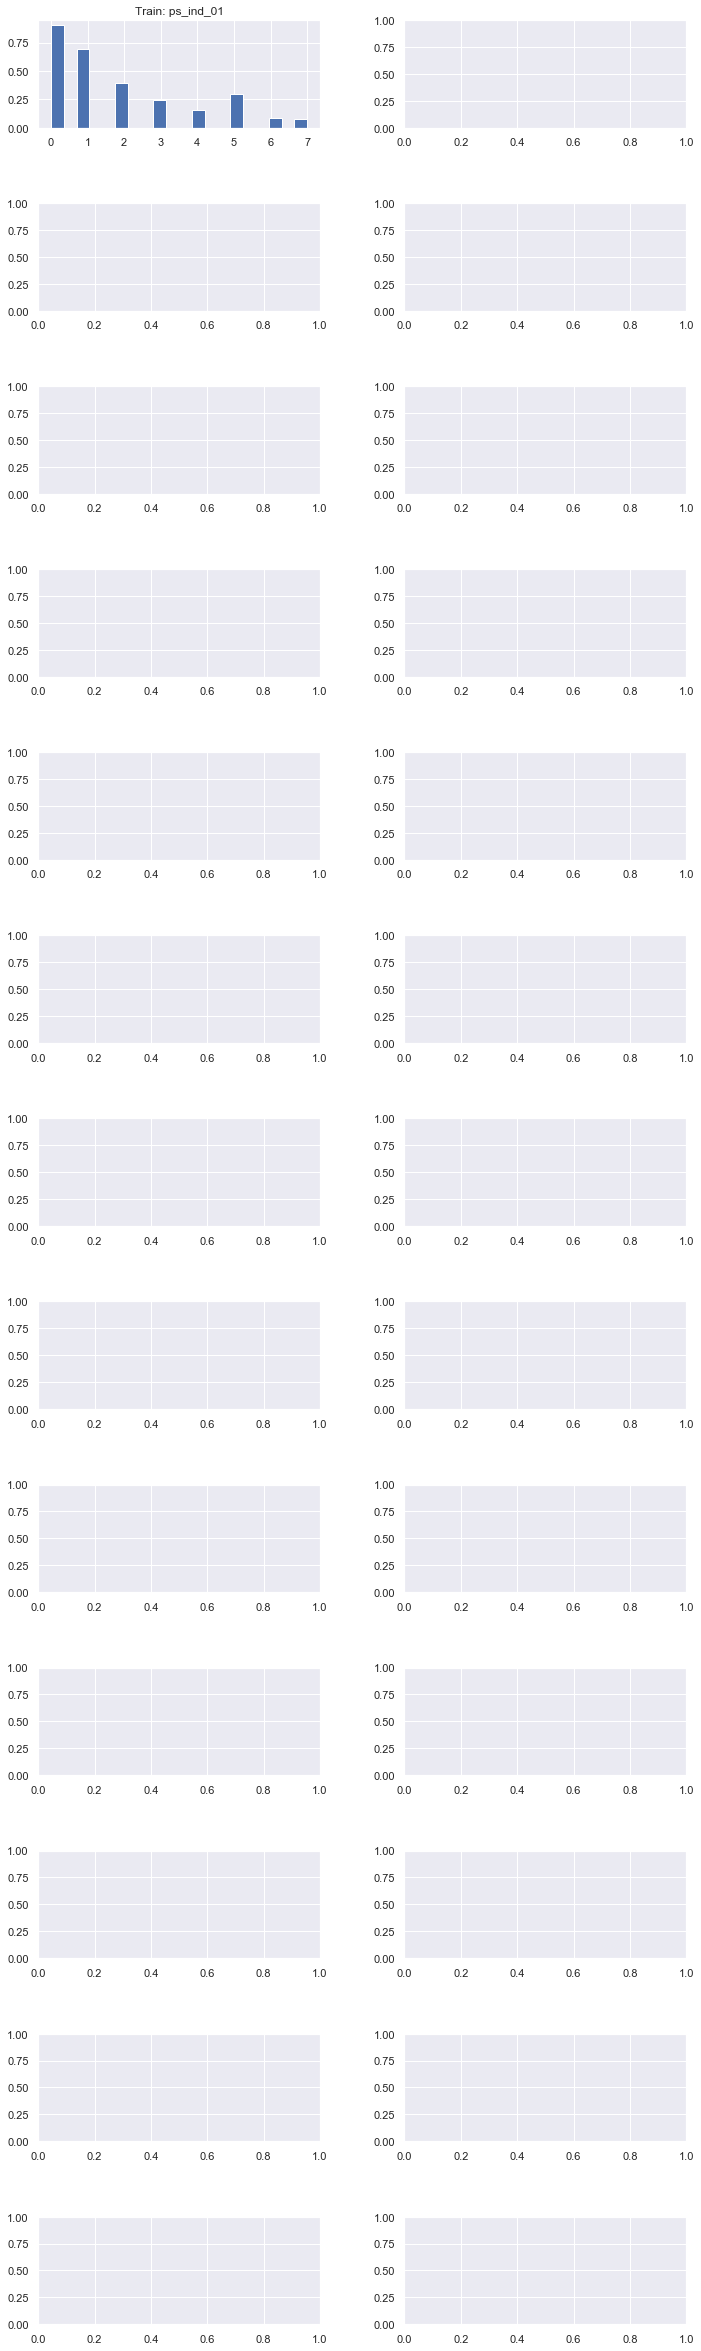

In [72]:
left  = 0  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.7   # the amount of height reserved for white space between subplot

fig, axes = plt.subplots(13, 2, figsize=(10, 40))
plt.subplots_adjust(left=left, bottom=bottom, right=right, 
                    top=top, wspace=wspace, hspace=hspace)

for i, ax in enumerate(axes.ravel()):
    title = 'Train: ' + feature_list_etc[i]
    ax.hist(train[feature_list_etc[i]], bins=20, normed=True)
    ax.set_title(title)
    ax.text(0, 1.2, train[feature_list_etc[i]].head(), horizontalalignment='left',
            verticalalignment='top', style='italic',
       bbox={'facecolor':'red', 'alpha':0.2, 'pad':10}, transform=ax.transAxes)

In [78]:
train_null_columns = train_null.columns
test_null_columns = test_null.columns

In [79]:
etc_ordinal_features = ['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_reg_01',
 'ps_reg_02', 'ps_car_11', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08',
 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
 'ps_calc_14']
etc_continuous_features = ['ps_reg_03','ps_car_12','ps_car_13','ps_car_14',
                          'ps_car_15']

In [86]:
# train null column 채우기 
# For categorical and binary features with postfix, substitue null values with the most frequent value to avoid float number.
# For categorical and binary features which was assumed, substitue null values with the most frequent value to avoid float number.

for feature in train_null_columns:
    if 'cat' in feature or 'bin' in feature:
        train_null[feature].fillna(train_null[feature].value_counts().idxmax(), inplace=True)
    elif feature in etc_continuous_features:
        train_null[feature].fillna(train_null[feature].median(), inplace=True)
    elif feature in etc_ordinal_features:
        train_null[feature].fillna(train_null[feature].value_counts().idxmax(), inplace=True)
    else:
        print(feature)

In [90]:
for feature in test_null_columns:
    if 'cat' in feature or 'bin' in feature:
        test_null[feature].fillna(test_null[feature].value_counts().idxmax(), inplace=True)
    elif feature in etc_continuous_features:
        test_null[feature].fillna(test_null[feature].median(), inplace=True)
    elif feature in etc_ordinal_features:
        test_null[feature].fillna(test_null[feature].value_counts().idxmax(), inplace=True)
    else:
        print(feature)

In [91]:
for feature in train_null_columns:
    train[feature] = train_null[feature]

for feature in test_null_columns:
    test[feature] = test_null[feature]

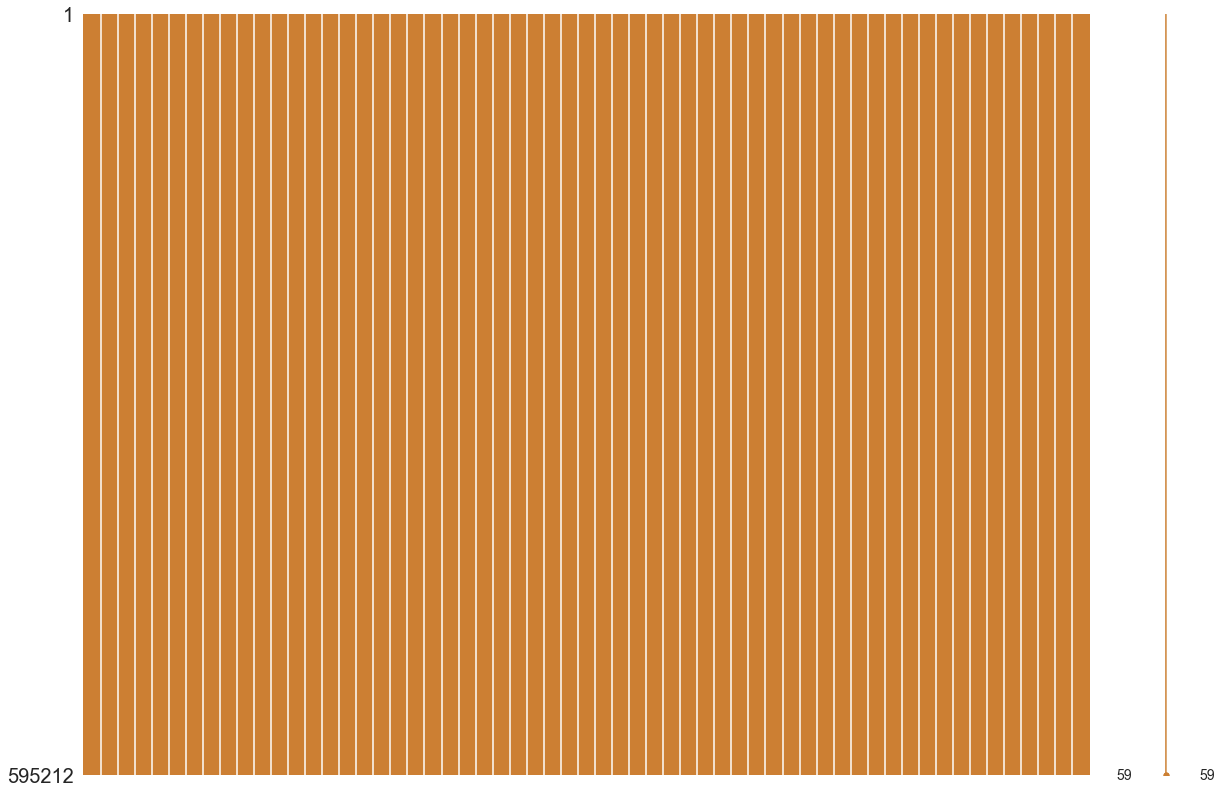

In [92]:
msno.matrix(df=train.iloc[:,:], figsize=(20,14), color=(0.8, 0.5,0.2))

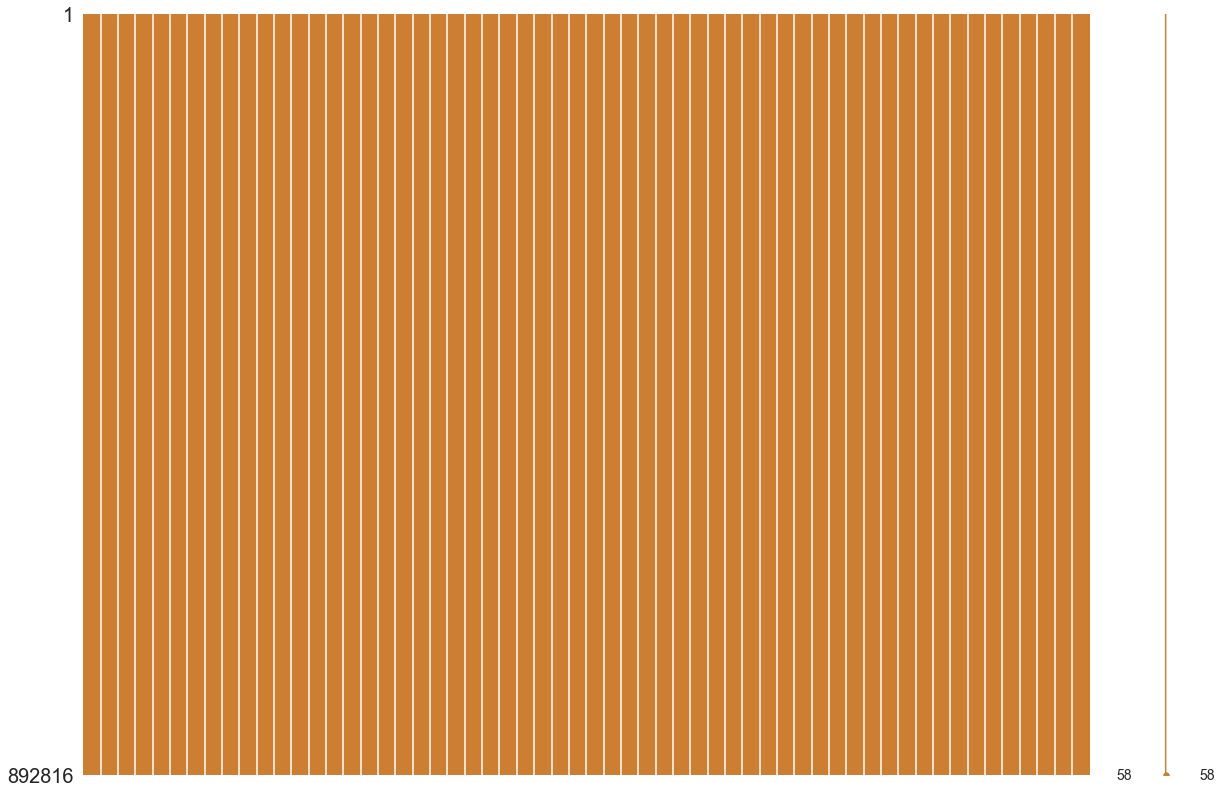

In [93]:
msno.matrix(df=test.iloc[:,:], figsize=(20,14), color=(0.8, 0.5,0.2))

### one-hot encoding for categorical data

In [100]:
def oneHotEncode_dataframe(df, features):
    for feature in features:
        temp_onehot_encoded = pd.get_dummies(df[feature])
        column_names = ["{}_{}".format(feature, x) for x in temp_onehot_encoded.columns]
        temp_onehot_encoded.columns = column_names
        df = df.drop(feature, axis=1)
        df = pd.concat([df, temp_onehot_encoded], axis=1)
    return df

In [101]:
train = oneHotEncode_dataframe(train, feature_list_cat)
test = oneHotEncode_dataframe(test, feature_list_cat)

## prediction with xgboost

In [103]:
# define gini metric 
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  

    giniSum -= (len(actual) + 1) / 2.  
    return giniSum / len(actual)  

def gini_normalized(a, p):  
    return gini(a, p) / gini(a, a)  

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

### stratified shuffle split